## Image Classification using Artificial Neural Networks (ANN)
- Purpose: Use fully connected neural networks to classify images based on pixel values
- Architecture: Input layer → Hidden layers → Output layer

### Import Libraries and Setup

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import warnings
import ssl
import os

warnings.filterwarnings('ignore')

# Fix SSL certificate issue
ssl._create_default_https_context = ssl._create_unverified_context
os.environ['PYTHONHTTPSVERIFY'] = '0'

# Set random seeds for reproducibility
np.random.seed(42)
keras.utils.set_random_seed(42)

print("All libraries imported successfully!")
print(f"TensorFlow/Keras version: {keras.__version__}")
print(f"NumPy version: {np.__version__}")

All libraries imported successfully!
TensorFlow/Keras version: 3.11.3
NumPy version: 2.2.6


### Load and Explore Dataset

Loading MNIST dataset...
✓ Dataset loaded successfully using keras.datasets

Original Dataset Information:
Training samples: 60,000
Test samples: 10,000
Image shape: 28 x 28
Number of classes: 10

Preprocessed Data:
Training data shape: (60000, 28, 28, 1)
Test data shape: (10000, 28, 28, 1)
Training labels shape: (60000, 10)
Test labels shape: (10000, 10)
Pixel value range: [0.00, 1.00]


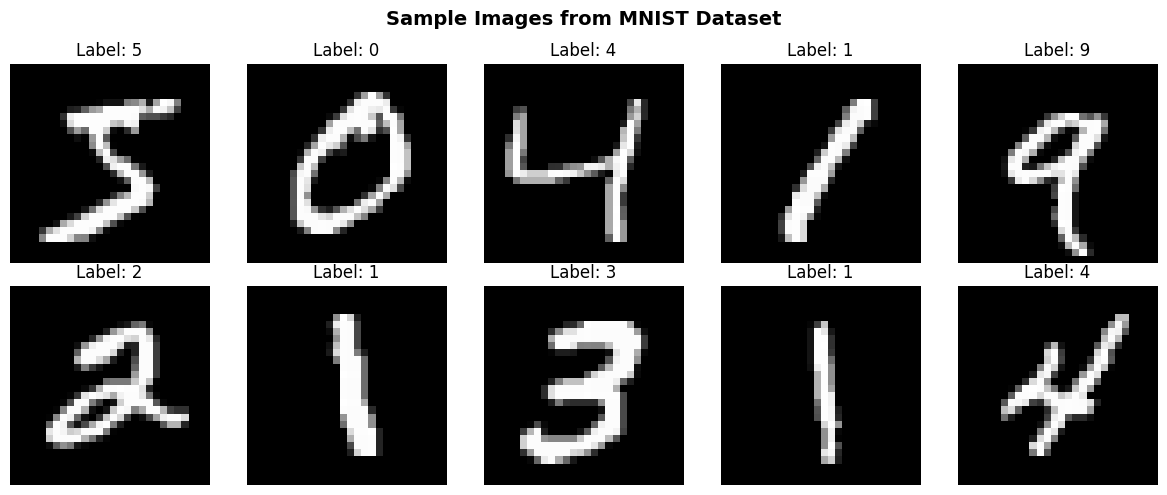

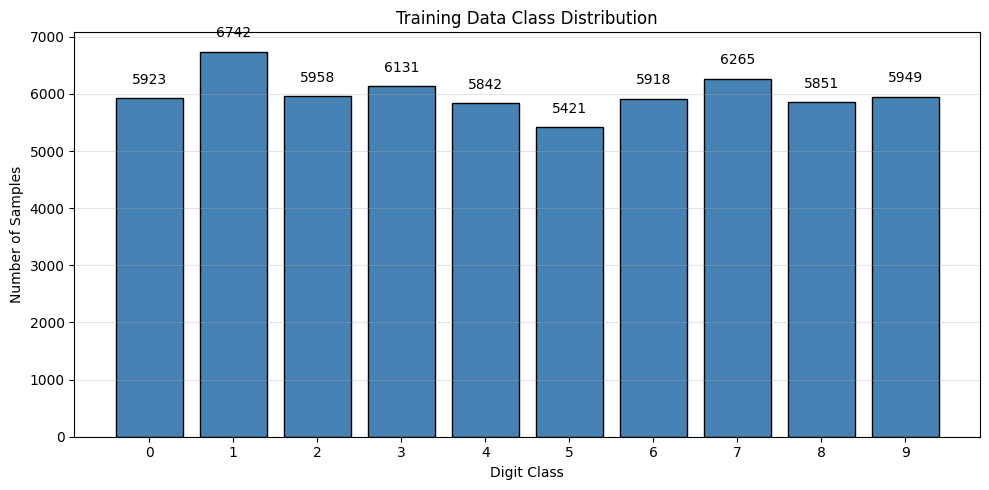

In [9]:
import numpy as np
import ssl
import urllib.request
import os

# Multiple approaches to fix SSL issue
try:
    ssl._create_default_https_context = ssl._create_unverified_context
    os.environ['PYTHONHTTPSVERIFY'] = '0'
except:
    pass

# Try to load MNIST dataset with multiple fallback methods
print("Loading MNIST dataset...")

# Method 1: Try standard keras load
try:
    (X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
    print("✓ Dataset loaded successfully using keras.datasets")
    
except Exception as e:
    print(f"Method 1 failed: {e}")
    print("\nTrying alternative method...")
    
    # Method 2: Manual download
    try:
        cache_dir = os.path.expanduser('~/.keras/datasets')
        os.makedirs(cache_dir, exist_ok=True)
        mnist_path = os.path.join(cache_dir, 'mnist.npz')
        
        if not os.path.exists(mnist_path):
            print("Downloading MNIST dataset manually...")
            url = 'https://storage.googleapis.com/tensorflow/tf-keras-datasets/mnist.npz'
            
            # Create opener that ignores SSL
            context = ssl._create_unverified_context()
            opener = urllib.request.build_opener(urllib.request.HTTPSHandler(context=context))
            urllib.request.install_opener(opener)
            
            urllib.request.urlretrieve(url, mnist_path)
            print("✓ Download complete!")
        
        # Load from file
        with np.load(mnist_path, allow_pickle=True) as f:
            X_train, y_train = f['x_train'], f['y_train']
            X_test, y_test = f['x_test'], f['y_test']
        
        print("✓ Dataset loaded successfully from local file")
        
    except Exception as e2:
        print(f"Method 2 failed: {e2}")
        print("\nTrying sklearn method...")
        
        # Method 3: Use sklearn
        try:
            from sklearn.datasets import fetch_openml
            
            print("Loading MNIST from sklearn (this may take a moment)...")
            mnist = fetch_openml('mnist_784', version=1, parser='auto', as_frame=False)
            X_all = mnist.data.reshape(-1, 28, 28).astype('uint8')
            y_all = mnist.target.astype('uint8')
            
            # Split into train and test
            X_train = X_all[:60000]
            y_train = y_all[:60000]
            X_test = X_all[60000:]
            y_test = y_all[60000:]
            
            print("✓ Dataset loaded successfully from sklearn")
            
        except Exception as e3:
            print(f"Method 3 failed: {e3}")
            print("\n❌ All methods failed. Please download the dataset manually.")
            print("\nManual download instructions:")
            print("1. Download from: https://storage.googleapis.com/tensorflow/tf-keras-datasets/mnist.npz")
            print("2. Save to: ~/.keras/datasets/mnist.npz")
            print("3. Re-run this cell")
            raise Exception("Could not load MNIST dataset")

print(f"\nOriginal Dataset Information:")
print(f"Training samples: {len(X_train):,}")
print(f"Test samples: {len(X_test):,}")
print(f"Image shape: {X_train.shape[1]} x {X_train.shape[2]}")
print(f"Number of classes: {len(np.unique(y_train))}")

# Normalize pixel values to [0, 1]
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Reshape for CNN (add channel dimension)
X_train_cnn = X_train.reshape(-1, 28, 28, 1)
X_test_cnn = X_test.reshape(-1, 28, 28, 1)

# Convert labels to categorical (one-hot encoding)
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

print(f"\nPreprocessed Data:")
print(f"Training data shape: {X_train_cnn.shape}")
print(f"Test data shape: {X_test_cnn.shape}")
print(f"Training labels shape: {y_train_cat.shape}")
print(f"Test labels shape: {y_test_cat.shape}")
print(f"Pixel value range: [{X_train_cnn.min():.2f}, {X_train_cnn.max():.2f}]")

# Display sample images
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i], cmap='gray')
    ax.set_title(f'Label: {y_train[i]}')
    ax.axis('off')
plt.suptitle('Sample Images from MNIST Dataset', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Show class distribution
unique, counts = np.unique(y_train, return_counts=True)
plt.figure(figsize=(10, 5))
plt.bar(unique, counts, color='steelblue', edgecolor='black')
plt.xlabel('Digit Class')
plt.ylabel('Number of Samples')
plt.title('Training Data Class Distribution')
plt.xticks(unique)
plt.grid(axis='y', alpha=0.3)
for i, (digit, count) in enumerate(zip(unique, counts)):
    plt.text(digit, count + 200, str(count), ha='center', va='bottom')
plt.tight_layout()
plt.show()

### Preprocess Data for ANN

Original data type: float32
Normalized data type: float32
Normalized pixel range: [0.0, 0.003921568859368563]

Preprocessed Data Shapes:
Training data: (60000, 784)
Test data: (10000, 784)
Training labels: (60000, 10)
Test labels: (10000, 10)

Sample flattened image (first 20 pixels):
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

Sample one-hot encoded label for digit 5:
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


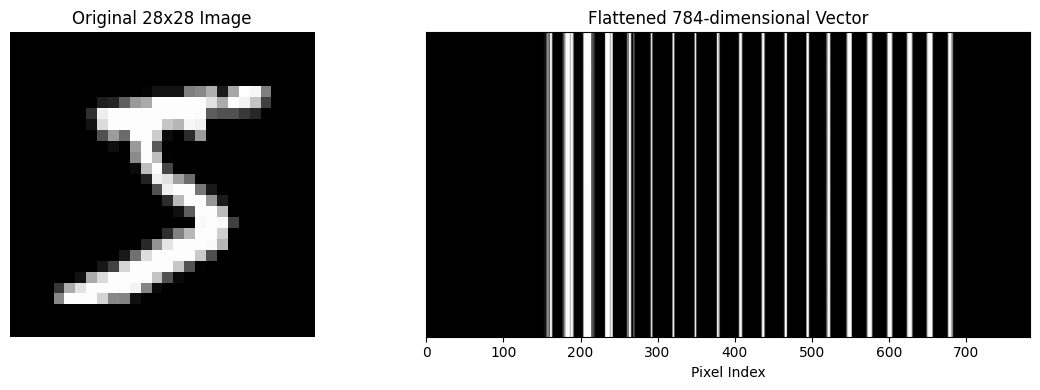

In [10]:
# Normalize pixel values to [0, 1]
X_train_ann = X_train.astype('float32') / 255.0
X_test_ann = X_test.astype('float32') / 255.0

print("Original data type:", X_train.dtype)
print("Normalized data type:", X_train_ann.dtype)
print(f"Normalized pixel range: [{X_train_ann.min()}, {X_train_ann.max()}]")

# Flatten images from 28x28 to 784
X_train_ann = X_train_ann.reshape(-1, 28*28)
X_test_ann = X_test_ann.reshape(-1, 28*28)

# Convert labels to categorical (one-hot encoding)
y_train_ann = keras.utils.to_categorical(y_train, 10)
y_test_ann = keras.utils.to_categorical(y_test, 10)

print(f"\nPreprocessed Data Shapes:")
print(f"Training data: {X_train_ann.shape}")
print(f"Test data: {X_test_ann.shape}")
print(f"Training labels: {y_train_ann.shape}")
print(f"Test labels: {y_test_ann.shape}")

print(f"\nSample flattened image (first 20 pixels):")
print(X_train_ann[0][:20])
print(f"\nSample one-hot encoded label for digit {y_train[0]}:")
print(y_train_ann[0])

# Visualize the flattening process
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].imshow(X_train[0], cmap='gray')
axes[0].set_title('Original 28x28 Image')
axes[0].axis('off')

axes[1].imshow(X_train_ann[0].reshape(1, -1), cmap='gray', aspect='auto')
axes[1].set_title('Flattened 784-dimensional Vector')
axes[1].set_xlabel('Pixel Index')
axes[1].set_yticks([])
plt.tight_layout()
plt.show()

### Build ANN Model

In [11]:
# Build the ANN model
print("Building ANN model...")
ann_model = keras.Sequential([
    layers.Input(shape=(784,), name='input_layer'),
    layers.Dense(512, activation='relu', name='hidden_layer_1'),
    layers.Dropout(0.2, name='dropout_1'),
    layers.Dense(256, activation='relu', name='hidden_layer_2'),
    layers.Dropout(0.2, name='dropout_2'),
    layers.Dense(128, activation='relu', name='hidden_layer_3'),
    layers.Dense(10, activation='softmax', name='output_layer')
], name='ANN_Model')

# Compile the model
ann_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display model architecture
print("\nModel Architecture:")
ann_model.summary()

# Count parameters
total_params = ann_model.count_params()
print(f"\nTotal trainable parameters: {total_params:,}")

# Visualize model architecture
print("\nLayer-wise parameter breakdown:")
for layer in ann_model.layers:
    if hasattr(layer, 'count_params'):
        print(f"  {layer.name}: {layer.count_params():,} parameters")

Building ANN model...

Model Architecture:


Model: "ANN_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_layer_1 (Dense)          │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_2 (Dense)          │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_3 (Dense)          │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 567,434 (2.16 MB)

 Trainable params: 567,434 (2.16 MB)

 Non-trainable params: 0 (0.00 B)


Total trainable parameters: 567,434

Layer-wise parameter breakdown:
  hidden_layer_1: 401,920 parameters
  dropout_1: 0 parameters
  hidden_layer_2: 131,328 parameters
  dropout_2: 0 parameters
  hidden_layer_3: 32,896 parameters
  output_layer: 1,290 parameters


### Train ANN Model

In [12]:
# Train the model
print("Training ANN model...")
print("="*70)

history_ann = ann_model.fit(
    X_train_ann, y_train_ann,
    batch_size=128,
    epochs=15,
    validation_split=0.1,
    verbose=1
)

print("\n" + "="*70)
print("Training completed!")
print("="*70)

# Display training summary
final_train_acc = history_ann.history['accuracy'][-1]
final_val_acc = history_ann.history['val_accuracy'][-1]
final_train_loss = history_ann.history['loss'][-1]
final_val_loss = history_ann.history['val_loss'][-1]

print(f"\nFinal Training Accuracy: {final_train_acc*100:.2f}%")
print(f"Final Validation Accuracy: {final_val_acc*100:.2f}%")
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")

Training ANN model...
Epoch 1/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7131 - loss: 0.8711 - val_accuracy: 0.8990 - val_loss: 0.3479
Epoch 2/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8894 - loss: 0.3636 - val_accuracy: 0.9310 - val_loss: 0.2280
Epoch 3/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9166 - loss: 0.2728 - val_accuracy: 0.9500 - val_loss: 0.1710
Epoch 4/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9341 - loss: 0.2157 - val_accuracy: 0.9592 - val_loss: 0.1374
Epoch 5/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9464 - loss: 0.1768 - val_accuracy: 0.9637 - val_loss: 0.1163
Epoch 6/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9533 - loss: 0.1543 - val_accuracy: 0.9702 - val_loss: 0.0985
Epoch 7/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9608 - loss: 0.1314 - val_accuracy: 0.9737 - val_loss: 0.0900
Epoch 8/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9636 - loss: 0.1

### Evaluate ANN Model

Evaluating model on test set...

Test Accuracy: 97.56%
Test Loss: 0.0783


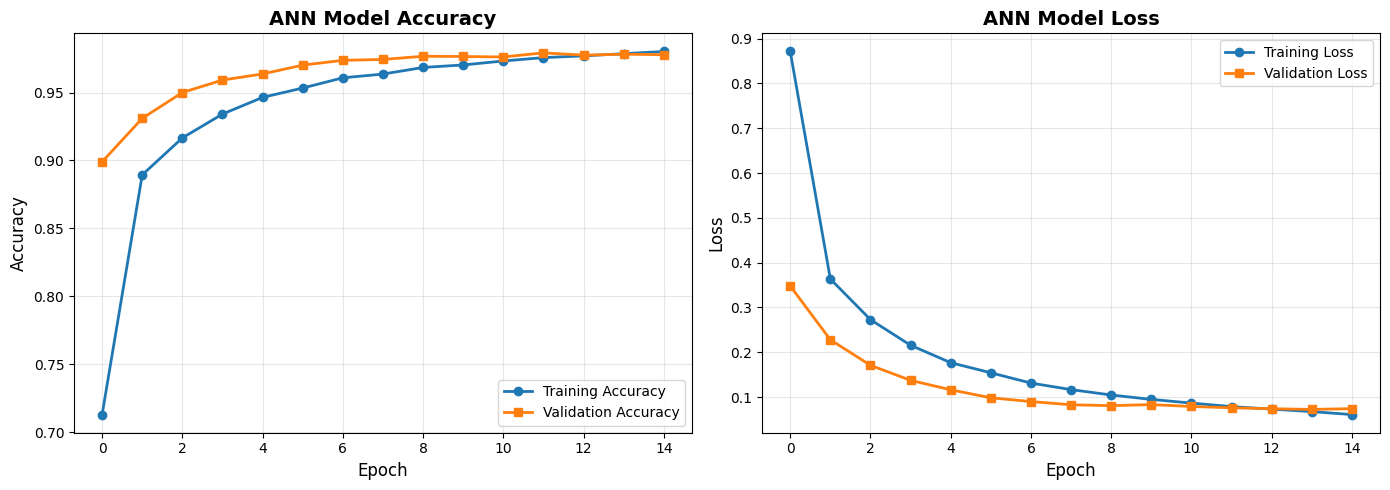

In [13]:
# Evaluate on test set
print("Evaluating model on test set...")
test_loss, test_accuracy = ann_model.evaluate(X_test_ann, y_test_ann, verbose=0)

print(f"\n{'='*70}")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")
print(f"{'='*70}")

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy plot
axes[0].plot(history_ann.history['accuracy'], label='Training Accuracy', linewidth=2, marker='o')
axes[0].plot(history_ann.history['val_accuracy'], label='Validation Accuracy', linewidth=2, marker='s')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('ANN Model Accuracy', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Loss plot
axes[1].plot(history_ann.history['loss'], label='Training Loss', linewidth=2, marker='o')
axes[1].plot(history_ann.history['val_loss'], label='Validation Loss', linewidth=2, marker='s')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title('ANN Model Loss', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Test Predictions and Analysis

Making predictions on test set...


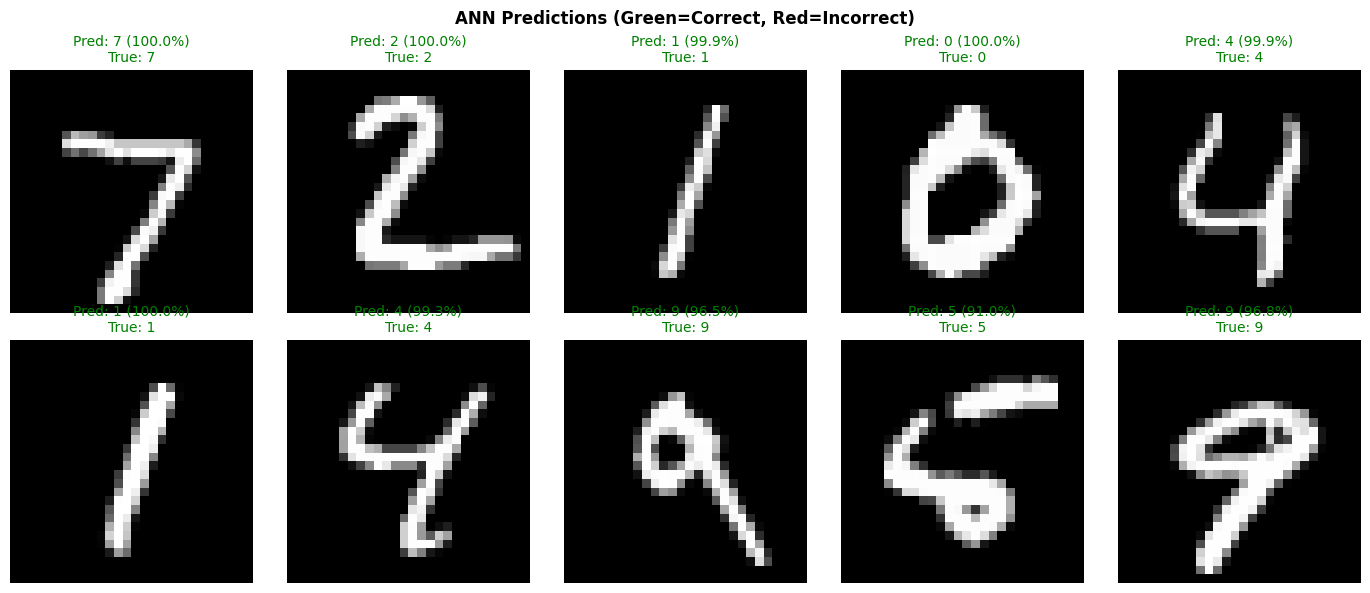


Total incorrect predictions: 244 out of 10000
Error rate: 2.44%


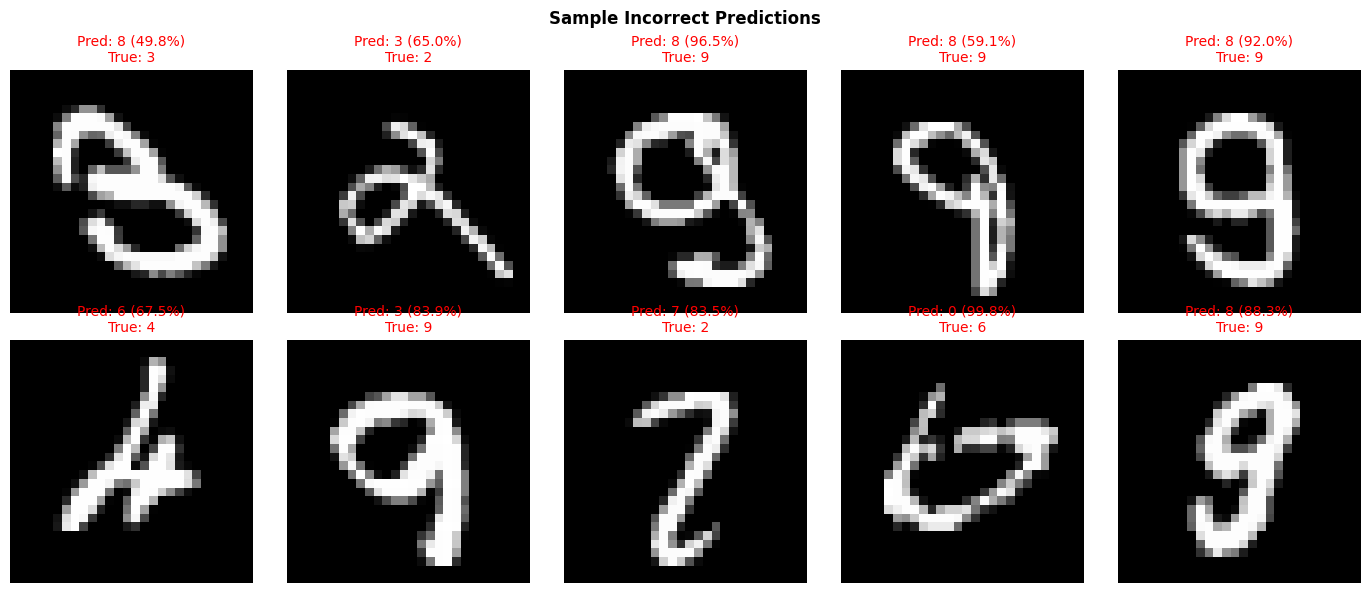

In [14]:
# Make predictions on test set
print("Making predictions on test set...")
y_pred_ann = ann_model.predict(X_test_ann, verbose=0)
y_pred_classes_ann = np.argmax(y_pred_ann, axis=1)

# Display predictions for sample images
fig, axes = plt.subplots(2, 5, figsize=(14, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_test[i], cmap='gray')
    pred_label = y_pred_classes_ann[i]
    true_label = y_test[i]
    confidence = y_pred_ann[i][pred_label] * 100
    
    color = 'green' if pred_label == true_label else 'red'
    ax.set_title(f'Pred: {pred_label} ({confidence:.1f}%)\nTrue: {true_label}', 
                 color=color, fontsize=10)
    ax.axis('off')

plt.suptitle('ANN Predictions (Green=Correct, Red=Incorrect)', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

# Find and display some incorrect predictions
incorrect_indices = np.where(y_pred_classes_ann != y_test)[0]
print(f"\nTotal incorrect predictions: {len(incorrect_indices)} out of {len(y_test)}")
print(f"Error rate: {len(incorrect_indices)/len(y_test)*100:.2f}%")

if len(incorrect_indices) > 0:
    fig, axes = plt.subplots(2, 5, figsize=(14, 6))
    for i, ax in enumerate(axes.flat):
        if i < len(incorrect_indices):
            idx = incorrect_indices[i]
            ax.imshow(X_test[idx], cmap='gray')
            pred_label = y_pred_classes_ann[idx]
            true_label = y_test[idx]
            confidence = y_pred_ann[idx][pred_label] * 100
            ax.set_title(f'Pred: {pred_label} ({confidence:.1f}%)\nTrue: {true_label}', 
                         color='red', fontsize=10)
        ax.axis('off')
    
    plt.suptitle('Sample Incorrect Predictions', fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()

### Classification Report and Confusion Matrix


Classification Report (ANN):
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.98      0.97      0.97      1010
           4       0.97      0.99      0.98       982
           5       0.97      0.97      0.97       892
           6       0.98      0.98      0.98       958
           7       0.98      0.97      0.97      1028
           8       0.95      0.98      0.96       974
           9       0.98      0.94      0.96      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



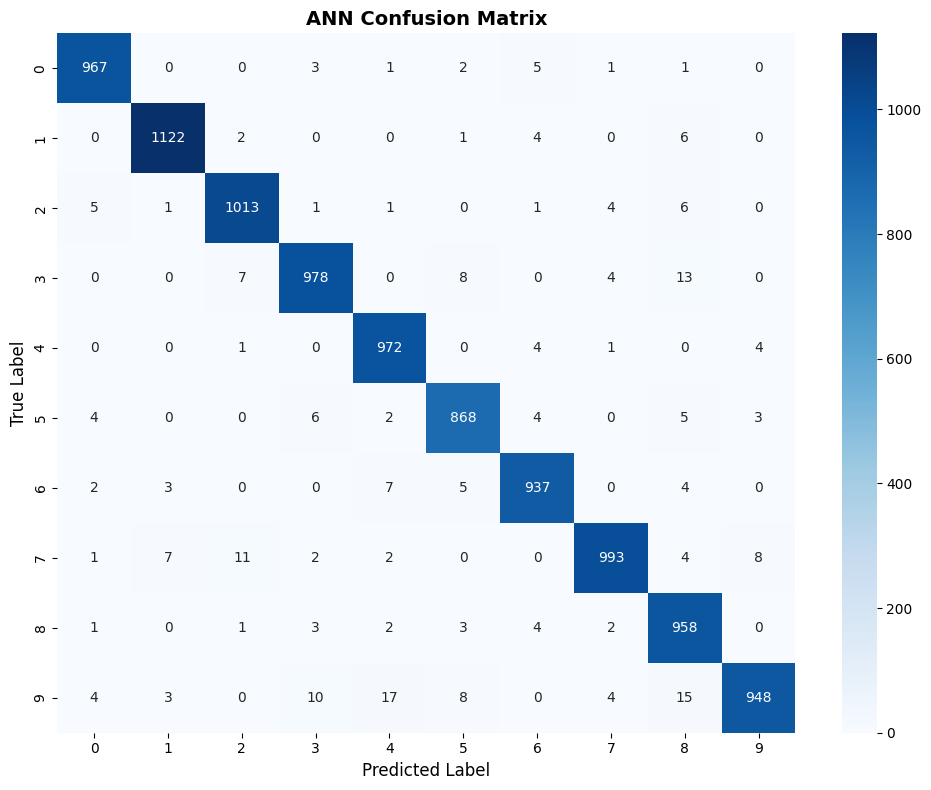

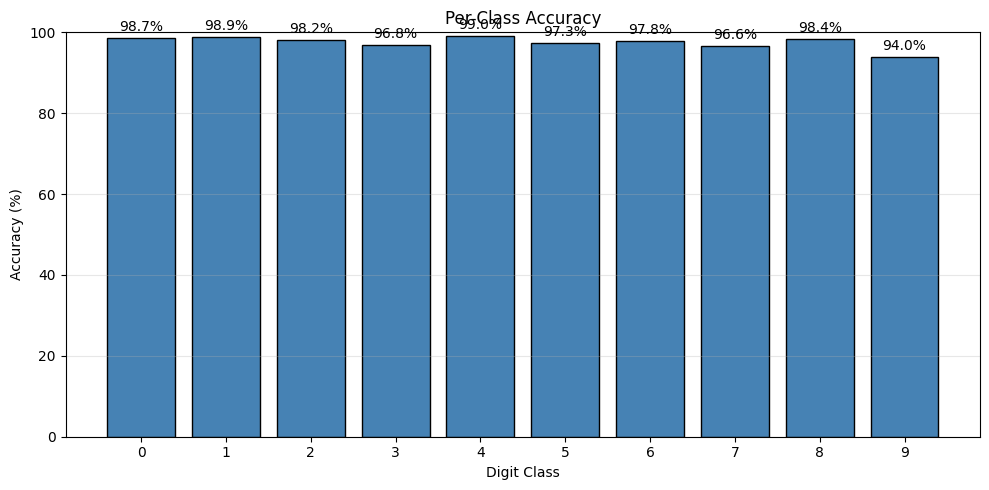

In [15]:
# Classification report
print("\nClassification Report (ANN):")
print("="*70)
print(classification_report(y_test, y_pred_classes_ann, 
                           target_names=[str(i) for i in range(10)]))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_classes_ann)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, 
            xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('ANN Confusion Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Per-class accuracy
per_class_accuracy = cm.diagonal() / cm.sum(axis=1)
plt.figure(figsize=(10, 5))
plt.bar(range(10), per_class_accuracy * 100, color='steelblue', edgecolor='black')
plt.xlabel('Digit Class')
plt.ylabel('Accuracy (%)')
plt.title('Per-Class Accuracy')
plt.xticks(range(10))
plt.ylim([0, 100])
plt.grid(axis='y', alpha=0.3)
for i, acc in enumerate(per_class_accuracy):
    plt.text(i, acc*100 + 1, f'{acc*100:.1f}%', ha='center', va='bottom')
plt.tight_layout()
plt.show()